# Signal/Background distribution example

Code from https://dbaumgartel.wordpress.com/2014/03/14/machine-learning-examples-scikit-learn-versus-tmva-cern-root/

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import pandas as pd

signal = pd.read_csv('.//data//500.csv', index_col=0)
background = pd.read_csv('.//data//background.csv', index_col=0)

signal.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

In [6]:
X = np.concatenate((signal, background))
y = np.concatenate((np.ones(signal.shape[0]),
                    np.zeros(background.shape[0])))#

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.4, random_state=2)
X_train,X_test, y_train,y_test = train_test_split(X_dev, y_dev, test_size=0.4, random_state=2)

In [7]:
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", 
                             n_estimators=100, learning_rate=2).fit(X_train, y_train)

In [8]:
# Total of four things: Training and Testing For signal and background

Classifier_training_S = BDT_clf.decision_function(X_train[y_train>0.5]).ravel()
Classifier_training_B = BDT_clf.decision_function(X_train[y_train<0.5]).ravel() 
Classifier_testing_S = BDT_clf.decision_function(X_test[y_test>0.5]).ravel()
Classifier_testing_B = BDT_clf.decision_function(X_test[y_test<0.5]).ravel() 

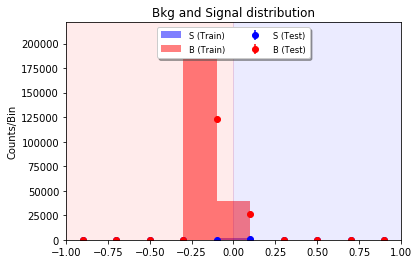

In [9]:
# This will be the min/max of our plots
c_max = 1
c_min = -1

# Get histograms of the classifiers
Histo_training_S = np.histogram(Classifier_training_S,bins=10,range=(c_min,c_max))
Histo_training_B = np.histogram(Classifier_training_B,bins=10,range=(c_min,c_max))
Histo_testing_S = np.histogram(Classifier_testing_S,bins=10,range=(c_min,c_max))
Histo_testing_B = np.histogram(Classifier_testing_B,bins=10,range=(c_min,c_max))

# Lets get the min/max of the Histograms
AllHistos= [Histo_training_S,Histo_training_B,Histo_testing_S,Histo_testing_B]
h_max = max([histo[0].max() for histo in AllHistos])*1.2
h_min = max([histo[0].min() for histo in AllHistos])

# Get the histogram properties (binning, widths, centers)
bin_edges = Histo_training_S[1]
bin_centers = ( bin_edges[:-1] + bin_edges[1:]  ) /2.
bin_widths = (bin_edges[1:] - bin_edges[:-1])
 
# To make error bar plots for the data, take the Poisson uncertainty sqrt(N)
ErrorBar_testing_S = np.sqrt(Histo_testing_S[0])
ErrorBar_testing_B = np.sqrt(Histo_testing_B[0])
 
# Draw objects
ax1 = plt.subplot(111)
 
# Draw solid histograms for the training data
ax1.bar(bin_centers-bin_widths/2.,Histo_training_S[0],facecolor='blue',linewidth=0,width=bin_widths,label='S (Train)',alpha=0.5)
ax1.bar(bin_centers-bin_widths/2.,Histo_training_B[0],facecolor='red',linewidth=0,width=bin_widths,label='B (Train)',alpha=0.5)
 
# Draw error-bar histograms for the testing data
ax1.errorbar(bin_centers, Histo_testing_S[0], yerr=ErrorBar_testing_S, xerr=None, ecolor='blue',c='blue',fmt='o',label='S (Test)')
ax1.errorbar(bin_centers, Histo_testing_B[0], yerr=ErrorBar_testing_B, xerr=None, ecolor='red',c='red',fmt='o',label='B (Test)')
 
# Make a colorful backdrop to show the clasification regions in red and blue
ax1.axvspan(0.0, c_max, color='blue',alpha=0.08)
ax1.axvspan(c_min,0.0, color='red',alpha=0.08)
 
# Adjust the axis boundaries (just cosmetic)
ax1.axis([c_min, c_max, h_min, h_max])
 
# Make labels and title
#%matplotlib notebook
plt.title("Bkg and Signal distribution")
#plt.xlabel("BDT")
plt.ylabel("Counts/Bin")
 
# Make legend with smalll font
legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')